**FlyVis Perturbations: Evaluate Model Performance**

This notebook will take in FlyVis models (pre-trained on optic flow task) that have been systematically perturbed in their connectivity, and then output various performance metrics on visual classification tasks and neuron tuning properties.

INPUTS: [FlyVis model]

OUTPUTS: {NETWORK}_performance.h5py

In [1]:
import os
import subprocess
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import torch

# flyvis imports
from flyvis import NetworkView
from flyvis.datasets.rendering import BoxEye
from flyvis.analysis.animations import HexScatter


import h5py
import datamate.io        # Where the function is defined
import datamate.directory # Where the function is actually CALLED causing the error

# Set up plotting
plt.rcParams["figure.figsize"] = [5, 3]
plt.rcParams["font.size"] = 6
plt.rcParams["figure.dpi"] = 200


data_path = Path("data/flyvis_data")
data_path.mkdir(parents=True, exist_ok=True)

env = os.environ.copy()
env["FLYVIS_ROOT_DIR"] = str(data_path)



network_view = NetworkView("flow/0000/000")

c:\Users\madis\Documents\Perturbations\fly_wire_perturbations\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[2026-01-05 23:39:48] network_view:122 Initialized network view at C:\Users\madis\Documents\Perturbations\fly_wire_perturbations\.venv\Lib\site-packages\flyvis\data\results\flow\0000\000


In [3]:
def fixed_write_h5(path, val):
    """
    A Windows-safe replacement that skips the 'read-before-write' check.
    """
    path = Path(path)
    path.parent.mkdir(parents=True, exist_ok=True)

    # Simple, safe write. No checking 'f["data"]', no 'unlink'.
    # This completely bypasses the logic causing your KeyError.
    with h5py.File(path, mode="w", libver="latest") as f:
        f.create_dataset("data", data=val)

# --- STEP 2: APPLY THE PATCH EVERYWHERE ---
print("Applying aggressive patches...")

# Patch 1: The definition
datamate.io._write_h5 = fixed_write_h5

# Patch 2: The copy inside directory.py (THIS IS THE KEY FIX)
# This forces the Directory class to use OUR function, not the old one it imported.
if hasattr(datamate.directory, "_write_h5"):
    datamate.directory._write_h5 = fixed_write_h5
    print(" -> Patched datamate.directory._write_h5")
else:
    print(" -> Warning: Could not find _write_h5 in directory module")


print("Importing flyvis...")
from flyvis import NetworkView

Applying aggressive patches...
 -> Patched datamate.directory._write_h5
Importing flyvis...


In [4]:
from flyvis import results_dir
from flyvis.network import NetworkView

# model are already sorted by task error
# we take the best task-performing model from the pre-sorted ensemble
network_view = NetworkView(results_dir / "flow/0000/000")

[2026-01-05 23:39:55] network_view:122 Initialized network view at C:\Users\madis\Documents\Perturbations\fly_wire_perturbations\.venv\Lib\site-packages\flyvis\data\results\flow\0000\000


In [5]:
import copy

In [6]:
from flyvis_cell_type_pert import FlyvisCellTypePert, PerturbationType
pert = FlyvisCellTypePert()

connectome = network_view.connectome
synapse_df = connectome.edges.to_df()
cell_type_df = synapse_df.groupby(['source_type', 'target_type']).size().reset_index(name='syn_count')

#original_network = network_view.init_network()
#perturbed_network = network_view.init_network()

original_network = network_view.init_network()
perturbed_network = copy.deepcopy(original_network)

pairs_to_perturb = [('Am', 'L3')]
pert_conn = pert.perturb(conn=cell_type_df,
                        perturbation_type=PerturbationType.PAIR_WISE,
                        pairs=pairs_to_perturb)

# validate the pert_weight is 0
pert_conn[pert_conn.pert_weight == 0]

#override network weights
def get_pair_index_in_network(perturbed_network, source_type, target_type):
    syn_str = perturbed_network.edge_params.syn_strength.keys
    for idx, (src, tar) in enumerate(syn_str):
        if src == source_type and tar == target_type:
            return idx
    return None

idx = get_pair_index_in_network(perturbed_network, 'Am', 'L3')
print('Am -> L3 index:', idx)
weight_before = perturbed_network.edge_params.syn_strength.raw_values[idx]
print('Weight before perturbation:', weight_before)

pert.override_network(perturbed_network, pert_conn)
weight_after = perturbed_network.edge_params.syn_strength.raw_values[idx]
print('Weight after perturbation:', weight_after)

[2026-01-05 23:39:58] logging_utils:23 epe not in C:\Users\madis\Documents\Perturbations\fly_wire_perturbations\.venv\Lib\site-packages\flyvis\data\results\flow\0000\000\validation, but 'loss' is. Falling back to 'loss'. You can rerun the ensemble validation to make appropriate recordings of the losses.
[2026-01-05 23:40:01] network:222 Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2026-01-05 23:40:01] chkpt_utils:36 Recovered network state.


Am -> L3 index: 127
Weight before perturbation: tensor(0.0402, grad_fn=<SelectBackward0>)
Weight after perturbation: tensor(0., grad_fn=<SelectBackward0>)


In [33]:
import torch
from copy import deepcopy
from flyvis_cell_type_pert import FlyvisCellTypePert, PerturbationType

pert = FlyvisCellTypePert()

connectome = network_view.connectome
synapse_df = connectome.edges.to_df()
cell_type_df = synapse_df.groupby(['source_type', 'target_type']).size().reset_index(name='syn_count')

# Initialize networks
original_network = network_view.init_network()
perturbed_network = network_view.init_network()

# CRITICAL: Use state_dict to create independent parameter copies
original_state = original_network.state_dict()
perturbed_state = {}

# Deep copy the state dict to ensure complete independence
for key, value in original_state.items():
    if isinstance(value, torch.Tensor):
        perturbed_state[key] = value.detach().clone()
    else:
        perturbed_state[key] = deepcopy(value)

# Load the copied state into perturbed network
perturbed_network.load_state_dict(perturbed_state)

# Now perturb
pairs_to_perturb = [('Am', 'L3')]
pert_conn = pert.perturb(
    conn=cell_type_df,
    perturbation_type=PerturbationType.PAIR_WISE,
    pairs=pairs_to_perturb
)

print("Perturbed connections:")
print(pert_conn[pert_conn.pert_weight == 0])

# Check and apply perturbation
def get_pair_index_in_network(network, source_type, target_type):
    syn_str = network.edge_params.syn_strength.keys
    for idx, (src, tar) in enumerate(syn_str):
        if src == source_type and tar == target_type:
            return idx
    return None

idx = get_pair_index_in_network(perturbed_network, 'Am', 'L3')
print(f'Am -> L3 index: {idx}')

weight_original = original_network.edge_params.syn_strength.raw_values[idx].item()
weight_before = perturbed_network.edge_params.syn_strength.raw_values[idx].item()
print(f'Original network Am->L3 weight: {weight_original}')
print(f'Perturbed network Am->L3 weight before: {weight_before}')

# Apply perturbation
pert.override_network(perturbed_network, pert_conn)

weight_after = perturbed_network.edge_params.syn_strength.raw_values[idx].item()
weight_original_after = original_network.edge_params.syn_strength.raw_values[idx].item()
print(f'Perturbed network Am->L3 weight after: {weight_after}')
print(f'Original network Am->L3 weight (should be unchanged): {weight_original_after}')

# Verify they're truly independent
if abs(weight_original_after - weight_original) < 1e-9:
    print("✓ Networks are independent!")
else:
    print("✗ WARNING: Original network was modified!")

[2026-01-05 23:22:19] chkpt_utils:36 Recovered network state.
[2026-01-05 23:22:19] chkpt_utils:36 Recovered network state.


Perturbed connections:
  source_type target_type  syn_count  pert_weight
4          Am          L3        721            0
Am -> L3 index: 127
Original network Am->L3 weight: 0.04021411016583443
Perturbed network Am->L3 weight before: 0.04021411016583443
Perturbed network Am->L3 weight after: 0.0
Original network Am->L3 weight (should be unchanged): 0.0
✗ WARNING: Original network was modified!


In [6]:
orig_weights = original_network.edge_params.syn_strength.raw_values
pert_weights = perturbed_network.edge_params.syn_strength.raw_values

# Find differences
weight_diff = (pert_weights - orig_weights).abs()
changed_mask = weight_diff > 1e-8  
changed_indices = torch.where(changed_mask)[0]

print(f"Number of connections changed: {len(changed_indices)}")

if len(changed_indices) > 0:
    syn_keys = original_network.edge_params.syn_strength.keys
    print("\nChanged connections:")
    for idx in changed_indices:
        src, tar = syn_keys[idx]
        print(f"  {src} -> {tar}: {orig_weights[idx].item():.4f} → {pert_weights[idx].item():.4f}")
else:
    print("Perturbed network is identical to original network.")

Number of connections changed: 1

Changed connections:
  Am -> L3: 0.0402 → 0.0000


In [ ]:
#!flyvis download-pretrained

[2026-01-04 17:17:21] utils:164 NumExpr defaulting to 4 threads.
[2026-01-04 17:17:33] __init__:49 file_cache is only supported with oauth2client<4.0.0
Progress results_umap_and_clustering.zip: 100%
Checksum OK for results_umap_and_clustering.zip.
Unpacked results_umap_and_clustering.zip.
Progress results_pretrained_models.zip: 100%
Checksum OK for results_pretrained_models.zip.
Unpacked results_pretrained_models.zip.


**Plot receptive and projective fields**

**Plot neural traces**

In [7]:
#supply random stimulus
from flyvis.utils.hex_utils import get_num_hexals

# Stimulation time and time step
T = 1  # seconds
dt = 1 / 50  # 1 / 200

# Create a random stimulus
stimulus = torch.randn(
    1, int(T / dt), 1, get_num_hexals(original_network.connectome.config.extent)
)

# Add the stimulus to a stimulus buffer
# For now, do this in parallel to original and perturbed networks
original_network.stimulus.add_input(stimulus)
perturbed_network.stimulus.add_input(stimulus)
# Run the model
with torch.no_grad():
    original_activity = original_network(original_network.stimulus(), dt=dt)
    perturbed_activity = perturbed_network(perturbed_network.stimulus(), dt=dt)

In [8]:
print("Shape of the original network activity:", original_activity.shape)
print("Shape of the perturbed network activity:", perturbed_activity.shape )

Shape of the original network activity: torch.Size([1, 50, 45669])
Shape of the perturbed network activity: torch.Size([1, 50, 45669])


example: visualize L3 (Am3-L3 synapses pertuerbed)
TO DO: change this so it automatically visualized perturbed cell type and its downstream partners

In [9]:
from flyvis.utils.activity_utils import LayerActivity as ActivityByType

# With ActivityByType one can easily access the activity all cells of a given type
# i.e. activity_by_type.T4c[:]
# or the activity of all central cells
# activity_by_type.central[:]
original_activity_by_type = ActivityByType(original_activity, original_network.connectome, keepref=True)
perturbed_activity_by_type = ActivityByType(perturbed_activity, perturbed_network.connectome, keepref=True)

In [23]:
print("Shape of the activity of all L3:", original_activity_by_type.L3[:].shape)

Shape of the activity of all L3: torch.Size([1, 250, 721])


Shape after slicing: torch.Size([50])


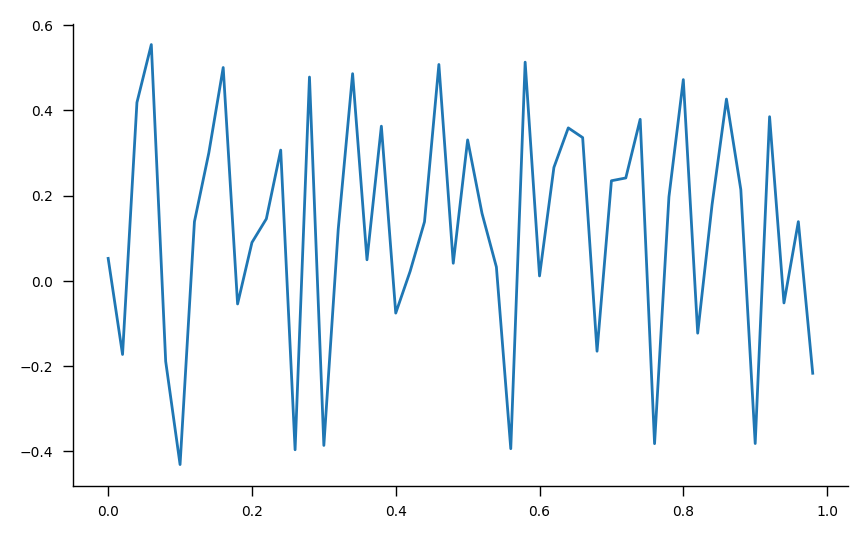

In [40]:
sliced = original_activity_by_type.L3[:, :, :1].squeeze().cpu()
print(f"Shape after slicing: {sliced.shape}")
plt.plot(time, sliced)

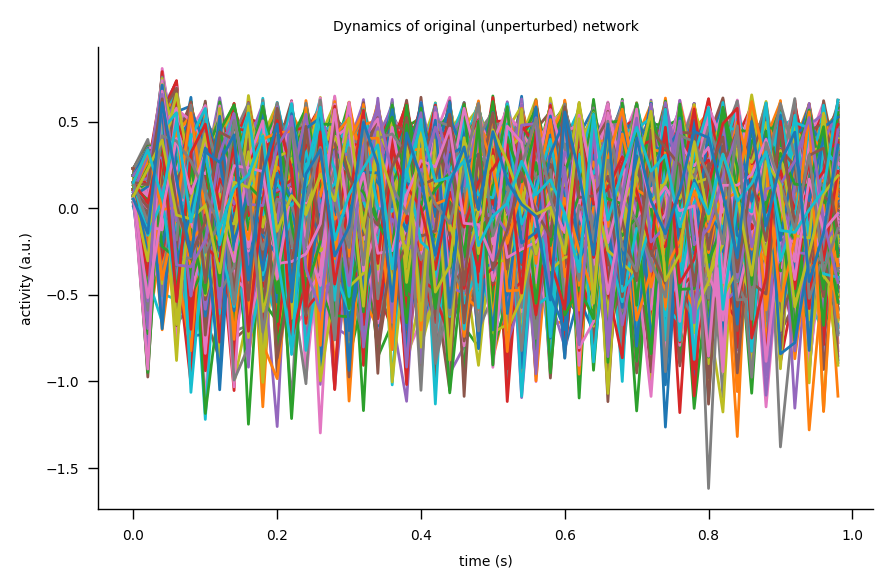

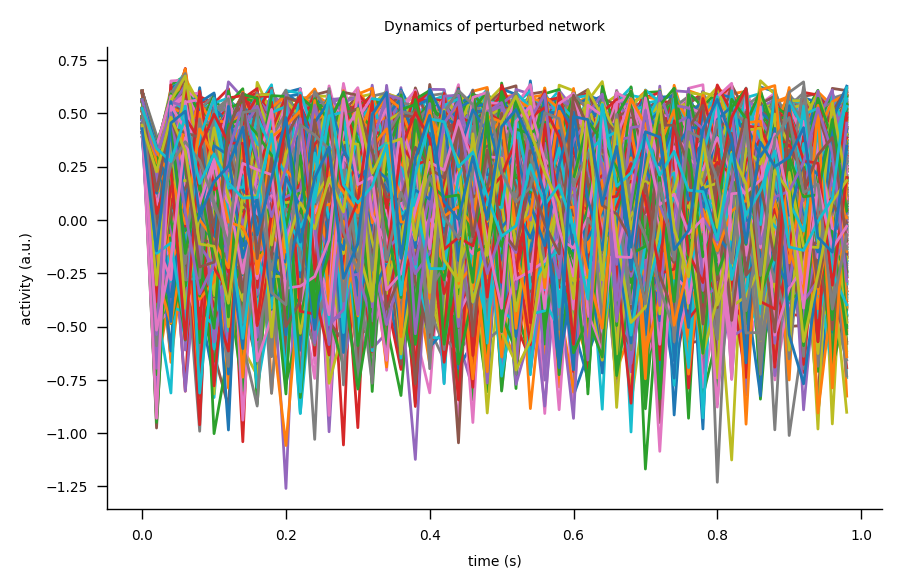

<Figure size 1000x600 with 0 Axes>

In [10]:


time = np.arange(0, original_activity.shape[1]) * dt
# plot the activity of L3 cells in original network
plt.plot(time, original_activity_by_type.L3[:,:,:].squeeze().cpu())
plt.xlabel("time (s)")
plt.ylabel("activity (a.u.)")
plt.title("Dynamics of original (unperturbed) network")
plt.show()

plt.plot(time, perturbed_activity_by_type.L3[:,:,:].squeeze().cpu())
plt.xlabel("time (s)")
plt.ylabel("activity (a.u.)")
plt.title("Dynamics of perturbed network")
plt.show()

plt.tight_layout()

**Plot response to Sintel movie set (naturalistic stimuli)**

**Plot tuning curves for direction and orientation selectivity**

Implement FlyVis moving edge stimulus and create tuning curve, then compare tuning curve for original, perturbed, and ground truth exp. data

In [7]:
from flyvis.datasets.moving_bar import MovingEdge
from flyvis.analysis.animations.hexscatter import HexScatter

In [8]:
# initialize dataset
# make the dataset
dataset = MovingEdge(
    offsets=[-10, 11],  # offset of bar from center in 1 * radians(2.25) led size
    intensities=[0, 1],  # intensity of bar
    speeds=[19],  # speed of bar in 1 * radians(5.8) / s
    height=80,  # height of moving bar in 1 * radians(2.25) led size
    post_pad_mode="continue",  # for post-stimulus period, continue with the last frame of the stimulus
    t_pre=1.0,  # duration of pre-stimulus period
    t_post=1.0,  # duration of post-stimulus period
    dt=1 / 200,  # temporal resolution of rendered video
    angles=list(np.arange(0, 360, 30)),  # motion direction (orthogonal to edge)
)

Animation interrupted. Displaying last frame.


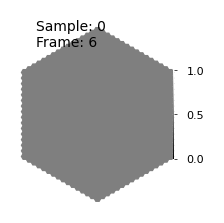

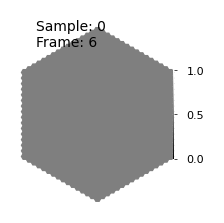

In [9]:
# view stimulus parameters
dataset.arg_df
# the dataset has four samples, one corresponding to each row

# visualize single sample
# %#matplotlib notebook
animation = HexScatter(
    dataset[3][None, ::25, None], vmin=0, vmax=1
)  # intensity=1, radius=6
animation.animate_in_notebook()

In [41]:
import shutil
import torch
from flyvis_cell_type_pert import FlyvisCellTypePert, PerturbationType

# Remove the old perturbed directory completely and start fresh
if perturbed_results_dir.exists():
    shutil.rmtree(perturbed_results_dir)

# Copy fresh
shutil.copytree(results_dir / "flow/0000/000", perturbed_results_dir)

# Create network views
original_network_view = NetworkView(results_dir / "flow/0000/000")
perturbed_network_view = NetworkView(perturbed_results_dir)

# Get original responses
original_stims_and_resps = original_network_view.moving_edge_responses(dataset)

# Apply perturbation
pert = FlyvisCellTypePert()
connectome = perturbed_network_view.connectome
synapse_df = connectome.edges.to_df()
cell_type_df = synapse_df.groupby(['source_type', 'target_type']).size().reset_index(name='syn_count')

temp_network = perturbed_network_view.init_network()
pairs_to_perturb = [('Am', 'L3'), ('R1', 'L1'), ('Mi1', 'T4c')]
pert_conn = pert.perturb(conn=cell_type_df,
                        perturbation_type=PerturbationType.PAIR_WISE,
                        pairs=pairs_to_perturb)
pert.override_network(temp_network, pert_conn)

# Load original checkpoint structure
checkpoint_path = perturbed_results_dir / "best_chkpt"
original_checkpoint = torch.load(results_dir / "flow/0000/000" / "best_chkpt", map_location='cpu')
original_checkpoint['network'] = temp_network.state_dict()

# Save to ALL possible checkpoint locations
torch.save(original_checkpoint, checkpoint_path)
print(f"Saved to: {checkpoint_path}")

# Also overwrite chkpts directory if it exists
chkpts_dir = perturbed_results_dir / "chkpts"
if chkpts_dir.exists():
    for chkpt_file in chkpts_dir.glob("*"):
        torch.save(original_checkpoint, chkpt_file)
        print(f"Saved to: {chkpt_file}")

# Remove checkpoints subdirectory if it exists
checkpoints_subdir = perturbed_results_dir / "checkpoints"
if checkpoints_subdir.exists():
    shutil.rmtree(checkpoints_subdir)
    print(f"Removed: {checkpoints_subdir}")

# Clear cache
cache_dir = perturbed_results_dir / "__cache__"
if cache_dir.exists():
    shutil.rmtree(cache_dir)

# Get perturbed responses
perturbed_stims_and_resps = perturbed_network_view.moving_edge_responses(dataset)

[2026-01-06 00:10:15] network_view:122 Initialized network view at C:\Users\madis\Documents\Perturbations\fly_wire_perturbations\.venv\Lib\site-packages\flyvis\data\results\flow\0000\000
[2026-01-06 00:10:15] network_view:122 Initialized network view at C:\Users\madis\Documents\Perturbations\fly_wire_perturbations\.venv\Lib\site-packages\flyvis\data\results\flow\0000\000_perturbed


C:\Users\madis\Documents\Perturbations\fly_wire_perturbations\.venv\Lib\site-packages\flyvis\data\results\flow\0000\000\__cache__\flyvis\analysis\stimulus_responses\compute_responses\23231df1ae76f91461faac65e3dc960a\output.h5


[2026-01-06 00:10:25] network:222 Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2026-01-06 00:10:25] chkpt_utils:36 Recovered network state.
[2026-01-06 00:10:25] chkpt_utils:36 Recovered network state.


Saved to: c:\Users\madis\Documents\Perturbations\fly_wire_perturbations\.venv\Lib\site-packages\flyvis\data\results\flow\0000\000_perturbed\best_chkpt
Saved to: c:\Users\madis\Documents\Perturbations\fly_wire_perturbations\.venv\Lib\site-packages\flyvis\data\results\flow\0000\000_perturbed\chkpts\chkpt_00000


[2026-01-06 00:10:29] network:757 Computing 24 stimulus responses.
[2026-01-06 00:12:14] xarray_joblib_backend:56 Store item C:\Users\madis\Documents\Perturbations\fly_wire_perturbations\.venv\Lib\site-packages\flyvis\data\results\flow\0000\000_perturbed\__cache__\flyvis\analysis\stimulus_responses\compute_responses\670a374eee810ef3730f545f081c45a7\output.h5


Top 20 most affected cell types:
   cell_type  mean_abs_diff
57      TmY4       0.000029
32        T2       0.000021
13     Lawf1       0.000019
64     TmY18       0.000013
30      Mi15       0.000009
37       T4c       0.000007
50      Tm5c       0.000007
22       Mi3       0.000006
62     TmY14       0.000004
35       T4a       0.000004
54      Tm28       0.000003
24       Mi9       0.000003
56      TmY3       0.000003
58     TmY5a       0.000002
61     TmY13       0.000002
49      Tm5b       0.000002
33       T2a       0.000002
41       T5c       0.000002
14     Lawf2       0.000002
34        T3       0.000002

Number of neurons with non-zero change: 63
Total number of neurons: 65

Plotting most affected cell type: TmY4


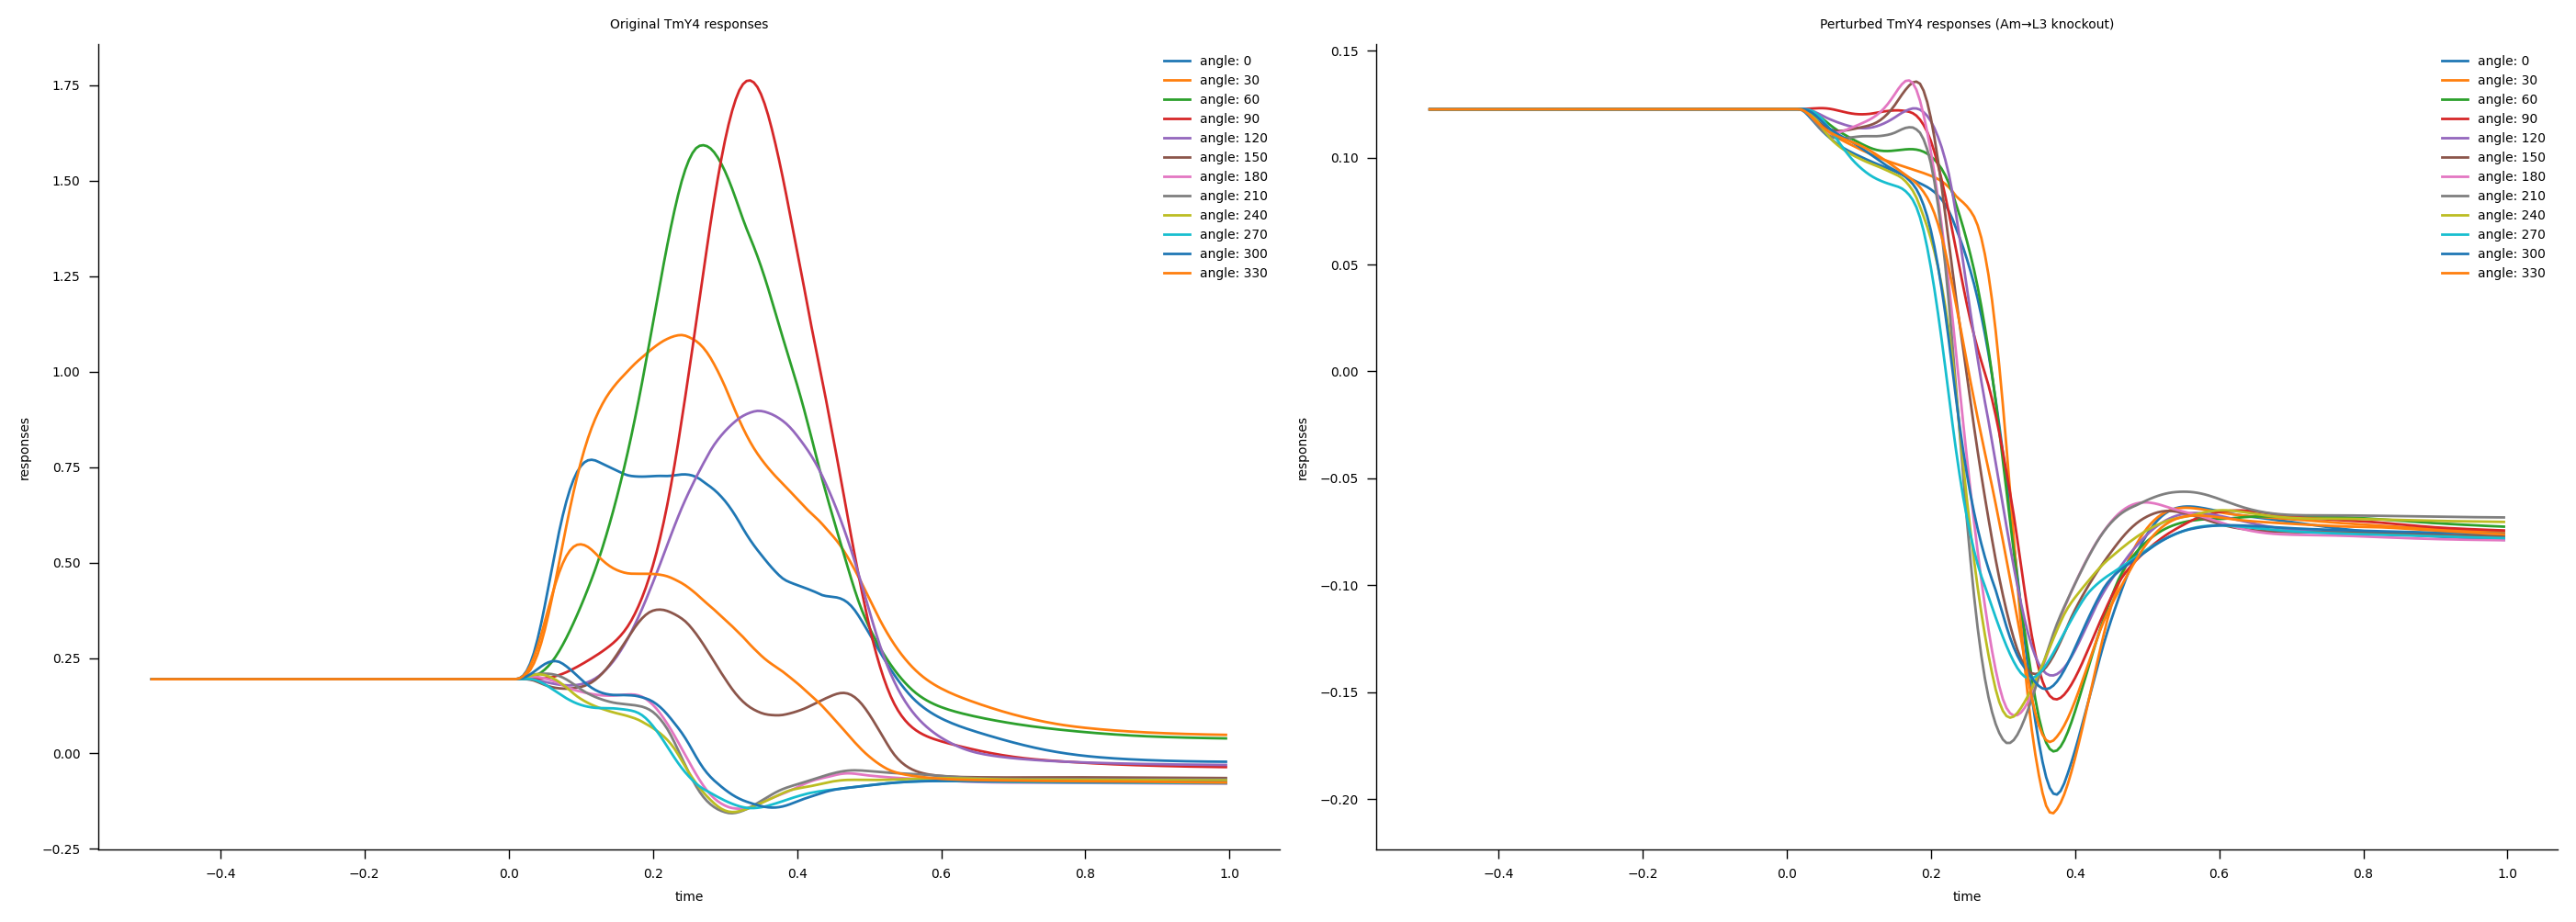

In [42]:
import numpy as np
import pandas as pd

# Calculate difference for each neuron
diff_per_neuron = np.abs(perturbed_responses.values - original_responses.values).mean(axis=(0, 1, 2))  # Average over network_id, sample, frame

# Create a dataframe with cell types and their differences
cell_types = original_responses.cell_type.values
diff_df = pd.DataFrame({
    'cell_type': cell_types,
    'mean_abs_diff': diff_per_neuron
})

# Sort by difference
diff_df_sorted = diff_df.sort_values('mean_abs_diff', ascending=False)

print("Top 20 most affected cell types:")
print(diff_df_sorted.head(20))

# Check if there are ANY changes
print(f"\nNumber of neurons with non-zero change: {(diff_per_neuron > 1e-9).sum()}")
print(f"Total number of neurons: {len(diff_per_neuron)}")

# Visualize top affected cell type
if diff_df_sorted.iloc[0]['mean_abs_diff'] > 1e-9:
    top_cell_type = diff_df_sorted.iloc[0]['cell_type']
    print(f"\nPlotting most affected cell type: {top_cell_type}")
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    plt.sca(axes[0])
    original_stims_and_resps["responses"].custom.where(
        cell_type=top_cell_type, intensity=1, time=">-0.5,<1.0"
    ).custom.plot_traces(x="time", legend_labels=["angle"])
    axes[0].set_title(f"Original {top_cell_type} responses")
    
    plt.sca(axes[1])
    perturbed_stims_and_resps["responses"].custom.where(
        cell_type=top_cell_type, intensity=1, time=">-0.5,<1.0"
    ).custom.plot_traces(x="time", legend_labels=["angle"])
    axes[1].set_title(f"Perturbed {top_cell_type} responses (Am→L3 knockout)")
    
    plt.tight_layout()

In [35]:
# Check L3 and Am specifically
L3_original = original_responses.sel(type='L3')
L3_perturbed = perturbed_responses.sel(type='L3')
L3_diff = np.abs(L3_perturbed.values - L3_original.values).mean()

Am_original = original_responses.sel(type='Am')
Am_perturbed = perturbed_responses.sel(type='Am')
Am_diff = np.abs(Am_perturbed.values - Am_original.values).mean()

print(f"L3 mean absolute difference: {L3_diff:.6f}")
print(f"Am mean absolute difference: {Am_diff:.6f}")

# Plot comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

plt.sca(axes[0])
original_stims_and_resps["responses"].custom.where(
    cell_type="L3", intensity=1, time=">-0.5,<1.0"
).custom.plot_traces(x="time", legend_labels=["angle"])
axes[0].set_title("Original L3 responses")

plt.sca(axes[1])
perturbed_stims_and_resps["responses"].custom.where(
    cell_type="L3", intensity=1, time=">-0.5,<1.0"
).custom.plot_traces(x="time", legend_labels=["angle"])
axes[1].set_title("Perturbed L3 responses (Am→L3 knockout)")

plt.tight_layout()

KeyError: "'type' is not a valid dimension or coordinate for Dataset with dimensions FrozenMappingWarningOnValuesAccess({'sample': 24, 'frame': 485, 'neuron': 65, 'network_id': 1})"

Text(0.5, 1.0, 'original L3 responses to moving edge (unperturbed)')

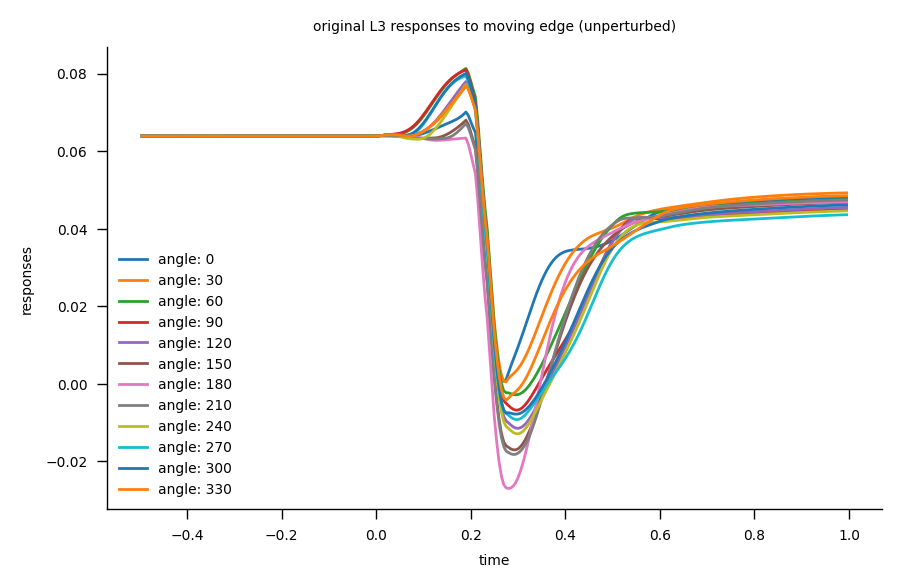

In [33]:
original_stims_and_resps["responses"].custom.where(
    cell_type="L3", intensity=1, time=">-0.5,<1.0"
).custom.plot_traces(x="time", legend_labels=["angle"])
ax = plt.gca()
ax.set_title("original L3 responses to moving edge (unperturbed)")


Text(0.5, 1.0, 'perturbed L3 responses to moving edge (Am→L3 knockout)')

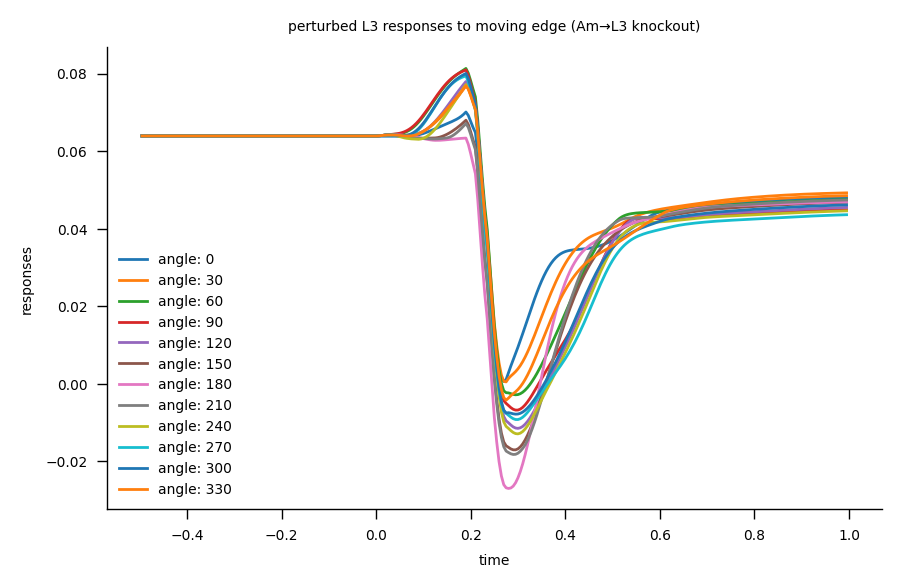

In [34]:
perturbed_stims_and_resps["responses"].custom.where(
    cell_type="L3", intensity=1, time=">-0.5,<1.0"
).custom.plot_traces(x="time", legend_labels=["angle"])
ax = plt.gca()
ax.set_title("perturbed L3 responses to moving edge (Am→L3 knockout)")

In [17]:
# For the original network responses (if you haven't already computed them)
original_stims_and_resps = network_view.moving_edge_responses(dataset)

# Now swap to the perturbed network
network_view.network = perturbed_network

# Get perturbed network responses
perturbed_stims_and_resps = network_view.moving_edge_responses(dataset)

TypeError: Network.forward() got an unexpected keyword argument 'checkpoint'

In [34]:
from flyvis import NetworkView
import copy
from flyvis_cell_type_pert import FlyvisCellTypePert, PerturbationType

# Create two separate NetworkView instances
original_network_view = NetworkView(results_dir / "flow/0000/000")
perturbed_network_view = NetworkView(results_dir / "flow/0000/000")

# Setup perturbation
pert = FlyvisCellTypePert()
connectome = original_network_view.connectome
synapse_df = connectome.edges.to_df()
cell_type_df = synapse_df.groupby(['source_type', 'target_type']).size().reset_index(name='syn_count')

# Initialize networks from each view
original_network = original_network_view.init_network()
perturbed_network = perturbed_network_view.init_network()

# Make them independent
perturbed_state = {k: v.clone() if isinstance(v, torch.Tensor) else v 
                   for k, v in original_network.state_dict().items()}
perturbed_network.load_state_dict(perturbed_state)

# Apply perturbation to only the perturbed network
pairs_to_perturb = [('Am', 'L3')]
pert_conn = pert.perturb(
    conn=cell_type_df,
    perturbation_type=PerturbationType.PAIR_WISE,
    pairs=pairs_to_perturb
)

pert.override_network(perturbed_network, pert_conn)

# Verify they're different
idx = 127  # Am -> L3 index
print(f"Original: {original_network.edge_params.syn_strength.raw_values[idx].item()}")
print(f"Perturbed: {perturbed_network.edge_params.syn_strength.raw_values[idx].item()}")

# Now you can use both NetworkViews independently
original_stims_and_resps = original_network_view.moving_edge_responses(dataset)
perturbed_stims_and_resps = perturbed_network_view.moving_edge_responses(dataset)

[2026-01-05 23:25:50] network_view:122 Initialized network view at C:\Users\madis\Documents\Perturbations\fly_wire_perturbations\.venv\Lib\site-packages\flyvis\data\results\flow\0000\000
[2026-01-05 23:25:50] network_view:122 Initialized network view at C:\Users\madis\Documents\Perturbations\fly_wire_perturbations\.venv\Lib\site-packages\flyvis\data\results\flow\0000\000
[2026-01-05 23:25:54] network:222 Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2026-01-05 23:25:54] chkpt_utils:36 Recovered network state.
[2026-01-05 23:25:57] network:222 Initialized network with NumberOfParams(free=734, fixed=2959) parameters.
[2026-01-05 23:25:57] chkpt_utils:36 Recovered network state.


Original: 0.04021411016583443
Perturbed: 0.0
C:\Users\madis\Documents\Perturbations\fly_wire_perturbations\.venv\Lib\site-packages\flyvis\data\results\flow\0000\000\__cache__\flyvis\analysis\stimulus_responses\compute_responses\23231df1ae76f91461faac65e3dc960a\output.h5
C:\Users\madis\Documents\Perturbations\fly_wire_perturbations\.venv\Lib\site-packages\flyvis\data\results\flow\0000\000\__cache__\flyvis\analysis\stimulus_responses\compute_responses\23231df1ae76f91461faac65e3dc960a\output.h5


In [61]:
# Create the names attribute as a tuple (cache contexts often use tuples)
network_view.names = (network_view.name,)
print(f"Original names: {network_view.names}")

# Compute original responses
network_view.network = original_network
print("Computing original network responses...")
original_stims_and_resps = network_view.moving_edge_responses(dataset)

# Change names for perturbed network
network_view.network = perturbed_network
network_view.names = (network_view.name + "_perturbed",)
print(f"Perturbed names: {network_view.names}")
print("Computing perturbed network responses...")
perturbed_stims_and_resps = network_view.moving_edge_responses(dataset)

Original names: ('flow\\0000\\000',)
Computing original network responses...
Perturbed names: ('flow\\0000\\000_perturbed',)
Computing perturbed network responses...


Text(0.5, 1.0, 'original L3 responses to moving edge (unperturbed)')

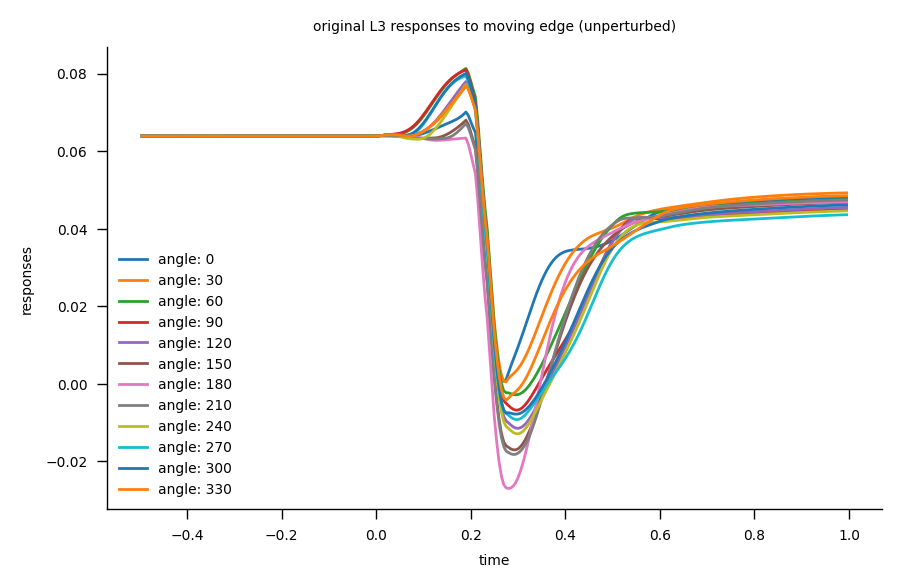

In [35]:
original_stims_and_resps["responses"].custom.where(
    cell_type="L3", intensity=1, time=">-0.5,<1.0"
).custom.plot_traces(x="time", legend_labels=["angle"])
ax = plt.gca()
ax.set_title("original L3 responses to moving edge (unperturbed)")

Text(0.5, 1.0, 'perturbed L3 responses to moving edge')

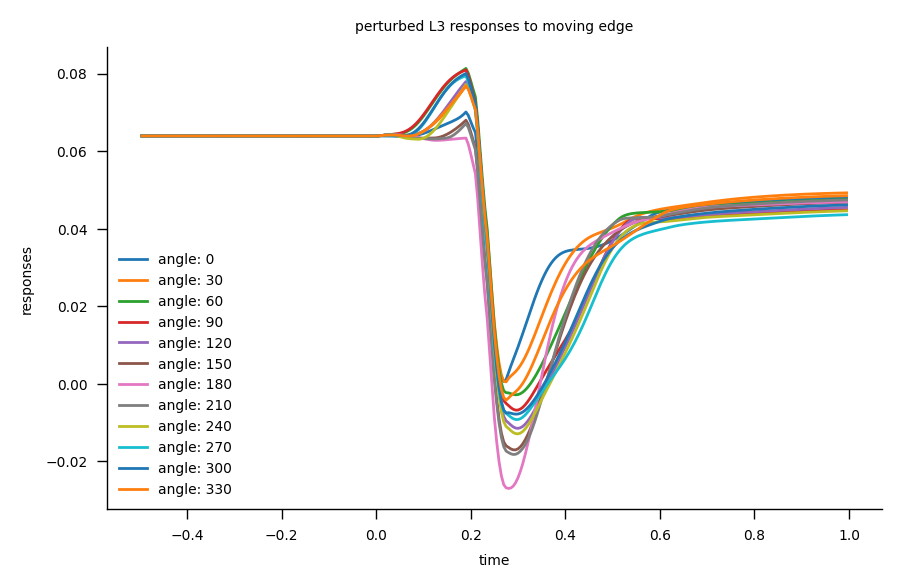

In [36]:
perturbed_stims_and_resps["responses"].custom.where(
    cell_type="L3", intensity=1, time=">-0.5,<1.0"
).custom.plot_traces(x="time", legend_labels=["angle"])
ax = plt.gca()
ax.set_title("perturbed L3 responses to moving edge")

compare direction selectivity index (a measure of the accuracy of the tuning curve to biological data)

In [ ]:
from flyvis.analysis.moving_bar_responses import direction_selectivity_index

In [ ]:
# get DSI for T4c cells (original vs perturbed)
original_dsis = direction_selectivity_index(original_stims_and_resps)
perturbed_dsis = direction_selectivity_index(perturbed_stims_and_resps)
print(f"Original T4c DSI: {original_dsis.custom.where(cell_type='T4c', intensity=1).item():.2f}")
print(f"Perturbed T4c DSI: {perturbed_dsis.custom.where(cell_type='T4c', intensity=1).item():.2f}")

#compare original and perturbed DSIs
delta_dsis = perturbed_dsis - original_dsis
print(f"Change in T4c DSI due to perturbation: {delta_dsis.custom.where(cell_type='T4c', intensity=1).item():.2f}")

In [ ]:
from flyvis.analysis.moving_bar_responses import preferred_direction

In [ ]:
original_pds = preferred_direction(original_stims_and_resps)
perturbed_pds = preferred_direction(perturbed_stims_and_resps)
print(
    f"Original T4c preferred direction: {original_pds.custom.where(cell_type='T4c', intensity=1).item() / np.pi * 180:.2f} degrees"
)
print(
    f"PerturbedT4c preferred direction: {perturbed_pds.custom.where(cell_type='T4c', intensity=1).item() / np.pi * 180:.2f} degrees"
)

In [ ]:
from flyvis.analysis.moving_bar_responses import plot_angular_tuning
plot_angular_tuning(original_stims_and_resps, cell_type="T4c", intensity=1)
plot_angular_tuning(perturbed_stims_and_resps, cell_type="T4c", intensity=1)

In [ ]:
from flyvis.analysis.moving_bar_responses import dsi_correlation_to_known

In [ ]:
original_dsi_corr = dsi_correlation_to_known(direction_selectivity_index(original_stims_and_resps)).median()
perturbed_dsi_corr = dsi_correlation_to_known(direction_selectivity_index(perturbed_stims_and_resps)).median()
print(f"Original DSI correlation to known: {original_dsi_corr:.2f}")
print(f"Perturbed DSI correlation to known: {perturbed_dsi_corr:.2f}")

In [ ]:
from flyvis.analysis.moving_bar_responses import correlation_to_known_tuning_curves

In [ ]:
original_corrs = correlation_to_known_tuning_curves(original_stims_and_resps)
perturbed_corrs = correlation_to_known_tuning_curves(perturbed_stims_and_resps)

original_t4_corrs = original_corrs.custom.where(cell_type=["T4a", "T4b", "T4c", "T4d"], intensity=1)
original_t5_corrs = original_corrs.custom.where(cell_type=["T5a", "T5b", "T5c", "T5d"], intensity=0)
perturbed_t4_corrs = perturbed_corrs.custom.where(cell_type=["T4a", "T4b", "T4c", "T4d"], intensity=1)
perturbed_t5_corrs = perturbed_corrs.custom.where(cell_type=["T5a", "T5b", "T5c", "T5d"], intensity=0)

print(
    f"original T4 tuning curve correlations: {original_t4_corrs.cell_type.values}\n{original_t4_corrs.squeeze().values}"
)
print(
    f"perturbed T4 tuning curve correlations: {perturbed_t4_corrs.cell_type.values}\n{perturbed_t4_corrs.squeeze().values}"
)

print(
    f"original T5 tuning curve correlations: {original_t5_corrs.cell_type.values}\n{original_t5_corrs.squeeze().values}"
)
print(
    f"perturbed T5 tuning curve correlations: {perturbed_t5_corrs.cell_type.values}\n{perturbed_t5_corrs.squeeze().values}"
)


plot T4c response traces (for ensemble)

In [ ]:
original_responses = (
    original_stims_and_resps["responses"]
    - original_stims_and_resps["responses"].custom.where(time=0).values
)

original_responses = original_responses / np.abs(original_responses).max(("sample", "frame"))

original_responses.custom.where(
    cell_type="T4c",
    intensity=1,
    time=">-0.5,<1.0",
    angle=90,
).custom.plot_traces(
    x="time", plot_kwargs=dict(color="tab:blue"), legend_labels=["network_id"]
)

<Axes: xlabel='time', ylabel='original responses'>

In [ ]:
perturbed_responses = (
    perturbed_stims_and_resps["responses"]
    - perturbed_stims_and_resps["responses"].custom.where(time=0).values
)

perturbed_responses = perturbed_responses / np.abs(perturbed_responses).max(("sample", "frame"))

perturbed_responses.custom.where(
    cell_type="T4c",
    intensity=1,
    time=">-0.5,<1.0",
    angle=90,
).custom.plot_traces(
    x="time", plot_kwargs=dict(color="tab:green"), legend_labels=["network_id"]
)

<Axes: xlabel='time', ylabel='perturbed responses'>

**Find and plot maximally exciting stimulus (artificial)**

**Quantify model performance on optic flow task**

**Other potential evaluation metrics:**

* dimensionality of population activity
* frequency and speed tuning curves
